In [47]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [48]:
historical = pd.read_csv('calls-2024-01-19.csv').set_index("Date").sort_index()

last_date  = pd.to_datetime(historical.index[-1])
next_date = last_date + pd.Timedelta(days=1)
next_date = next_date.strftime('%Y-%m-%d')

spx = yf.download("^SPX", start=historical.index[0], end=next_date)['Close']
irx = yf.download("^IRX", start=historical.index[0], end=next_date)['Close']

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [49]:
import numpy as np
from scipy.stats import norm

def BS_call_price(S, K, T, t, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.

    Parameters:
    S (float): Spot price of the underlying asset
    K (float): Strike price of the option
    T (float): Time to maturity (in years)
    t (float): Current time (usually 0 if calculating at present)
    r (float): Risk-free interest rate (annualized, expressed as a decimal)
    sigma (float): Volatility of the underlying asset (annualized, expressed as a decimal)

    Returns:
    float: Black-Scholes call option price
    """
    T = T - t  # Remaining time to maturity

    if T <= 0:  # Handle edge case where time to expiration is zero
        return max(S - K, 0)  # Call option payoff at expiration

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


In [50]:
from scipy.optimize import minimize

def calibrate_BS_full(sigma):
    temp_df = historical.copy()
    total = []

    for rows in temp_df.iterrows():
        date_index = rows[0]
        s = float(spx.loc[date_index].item())
        r = float(irx.loc[date_index].item())*0.01
        t = (pd.to_datetime(maturity_date) - pd.to_datetime(date_index)).days / 365

        for i, v in rows[1].to_dict().items():
            if not np.isnan(v):
                c = BS_call_price(s, float(i), t, 0, r, sigma)
                total.append((c - v)**2)
    mse = sum(total)/len(total)
    return mse


maturity_date = '2024-01-19'

bounds = [(0.001, 10)]
res = minimize(calibrate_BS_full, 2, bounds=bounds, method='L-BFGS-B')
sigma = res.x
print(sigma[0])

0.13909780181917927


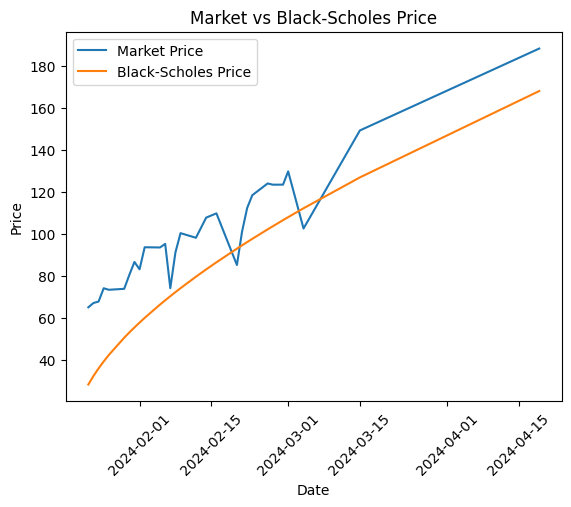

In [51]:
future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)

s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['BS']  = temp_df["Maturity"].apply(
    lambda x: BS_call_price(s0, K, T(x), 0, r, sigma)[0]
    )

plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market Price')
plt.plot(temp_df['Maturity'], temp_df['BS'], label='Black-Scholes Price')
plt.tick_params(axis='x', rotation=45)

plt.legend(['Market Price', 'Black-Scholes Price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market vs Black-Scholes Price")

plt.show()

In [52]:
print("Least Squares Error: ", ((temp_df['BS'] - temp_df['Close'])**2).mean())

Least Squares Error:  594.3623304086434


In [53]:
spx_on_maturity = yf.download("^SPX", start='2024-01-01', end='2024-12-31')['Close']
spx_on_maturity = spx_on_maturity[spx_on_maturity.index.isin(temp_df['Maturity'])]


temp_df['SPX'] = temp_df['Maturity'].map(spx_on_maturity.to_dict()['^SPX'])

temp_df['Payoff'] = temp_df['SPX'] - K
temp_df["Payoff Ratio"] = temp_df["Payoff"] / temp_df["Close"]

temp_df

[*********************100%***********************]  1 of 1 completed


,Maturity,Close,BS,SPX,Payoff,Payoff Ratio
13,2024-01-22,65.00,28.232865,4850.430176,75.430176,1.160464
31,2024-01-23,67.05,32.292818,4864.600098,89.600098,1.336318
53,2024-01-24,67.74,35.914359,4868.549805,93.549805,1.381013
75,2024-01-25,74.07,39.223852,4894.160156,119.160156,1.608751
99,2024-01-26,73.35,42.296601,4890.970215,115.970215,1.581053
125,2024-01-29,73.80,50.516932,4927.930176,152.930176,2.072225
148,2024-01-30,80.41,53.010681,4924.970215,149.970215,1.865069
175,2024-01-31,86.60,55.409462,4845.649902,70.649902,0.815819
204,2024-02-01,83.10,57.724927,4906.189941,131.189941,1.578700
226,2024-02-02,93.60,59.966524,4958.609863,183.609863,1.961644


In [54]:
temp_df[temp_df['BS'] > temp_df['Close']]

,Maturity,Close,BS,SPX,Payoff,Payoff Ratio
429,2024-02-20,85.15,92.927307,4975.509766,200.509766,2.354783
575,2024-03-04,102.52,112.154138,5130.950195,355.950195,3.472007


In [55]:
top_ten_payoff_ratio = temp_df.sort_values(by='Payoff Ratio', ascending=False).head(10)
top_ten_payoff_ratio

,Maturity,Close,BS,SPX,Payoff,Payoff Ratio
575,2024-03-04,102.52,112.154138,5130.950195,355.950195,3.472007
281,2024-02-07,74.10,70.299725,4995.060059,220.060059,2.969771
559,2024-03-01,129.71,107.925858,5137.080078,362.080078,2.791458
458,2024-02-22,112.31,96.055430,5087.029785,312.029785,2.778290
474,2024-02-23,118.37,97.593015,5088.799805,313.799805,2.651008
526,2024-02-29,123.40,106.491725,5096.270020,321.270020,2.603485
338,2024-02-12,98.11,79.566798,5021.839844,246.839844,2.515950
317,2024-02-09,100.31,74.112141,5026.609863,251.609863,2.508323
508,2024-02-27,123.39,103.583630,5078.180176,303.180176,2.457089
296,2024-02-08,91.15,72.225255,4997.910156,222.910156,2.445531


Text(0.5, 1.0, 'Payoff Ratio')

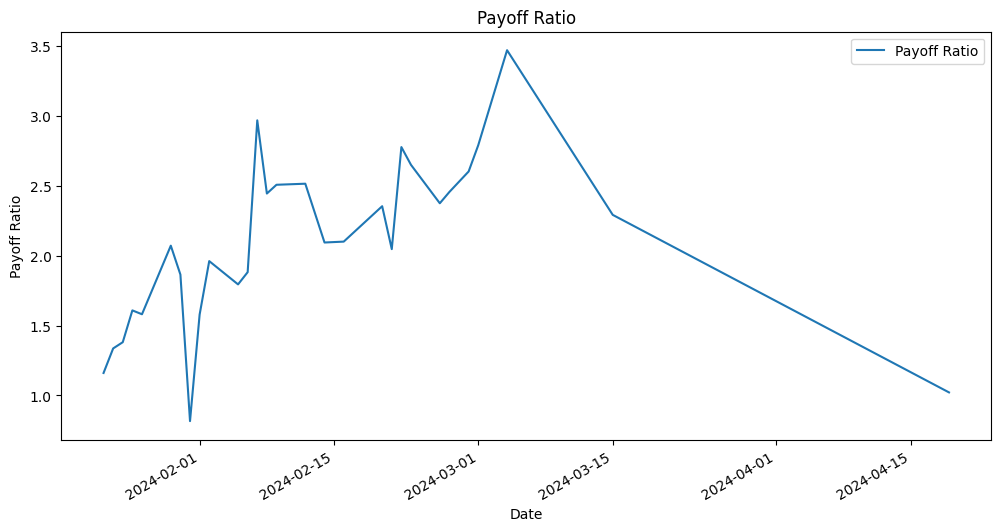

In [56]:
temp_df.plot(x='Maturity', y=['Payoff Ratio'], figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Payoff Ratio")
plt.title("Payoff Ratio")

In [57]:
np.corrcoef(np.abs(temp_df['Close']-temp_df['BS']), temp_df['Payoff Ratio'])

array([[ 1.        , -0.69450864],
       [-0.69450864,  1.        ]])